### Association of EuroCORDEX Models:

Association of RCMs, GCMs and Ensembles within the distribution:

In [3]:
import xarray
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import warnings
import matplotlib as mpl
import warnings
import cmasher as cmr
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

def get_cordex_addresses():
    models = pd.read_csv('cordex_models.txt', sep='\t')
    root = '/data/met/ukcordex/'
    directories = [root + models['GCM'][i] + '/' +
                   models['RCM'][i] + '/' +
                   models['Ensemble'][i] + '/dmo/'
                   for i in range(models.shape[0])]
    tas_files  = []
    hurs_files = []
    pr_files   = []
    wind_files = []
    err_indexs = []
    print(type(err_indexs))
    for i in range(models.shape[0]):
        try:
            for f_name in os.listdir(directories[i]):
                if f_name.startswith('tas_'):
                    tas_files.append(str(f_name))
                if f_name.startswith('hurs_'):
                    hurs_files.append(str(f_name))
                if f_name.startswith('sfcWind_'):
                    wind_files.append(str(f_name))
                if f_name.startswith('pr_'):
                    pr_files.append(str(f_name))
        except OSError as error:
            print(f'Inelligible directory at: {directories[i]}')
            err_indexs.append(int(i))
    for i in range(len(err_indexs)):
        del directories[err_indexs[i]]
    return directories,tas_files,hurs_files,wind_files,pr_files

###### Getting Model Indices:

In [4]:
cordex_models = pd.read_csv('/home/theo/cordex_models.txt', sep='\t')
gcms = ['CNRM-CERFACS-CNRM-CM5','ICHEC-EC-EARTH','IPSL-IPSL-CM5A-MR','MOHC-HadGEM2-ES','MPI-M-MPI-ESM-LR','NCC-NorESM1-M']
rcms = ['COSMO-crCLIM-v1-1','HadREM3-GA7-05','HIRHAM5','RACMO22E','RCA4','REMO2015','WRF381P']
ensembles = ['r1i1p1','r2i1p1','r3i1p1','r12i1p1']

gcm_inds = [cordex_models.GCM[cordex_models.GCM == gcms[0]].index.tolist(),
            cordex_models.GCM[cordex_models.GCM == gcms[1]].index.tolist(),
            cordex_models.GCM[cordex_models.GCM == gcms[2]].index.tolist(),
            cordex_models.GCM[cordex_models.GCM == gcms[3]].index.tolist(),
            cordex_models.GCM[cordex_models.GCM == gcms[4]].index.tolist(),
            cordex_models.GCM[cordex_models.GCM == gcms[5]].index.tolist()]

rcm_inds = [cordex_models.RCM[cordex_models.RCM == rcms[0]].index.tolist(),
            cordex_models.RCM[cordex_models.RCM == rcms[1]].index.tolist(),
            cordex_models.RCM[cordex_models.RCM == rcms[2]].index.tolist(),
            cordex_models.RCM[cordex_models.RCM == rcms[3]].index.tolist(),
            cordex_models.RCM[cordex_models.RCM == rcms[4]].index.tolist(),
            cordex_models.RCM[cordex_models.RCM == rcms[5]].index.tolist(),
            cordex_models.RCM[cordex_models.RCM == rcms[6]].index.tolist()]

ensemble_inds = [cordex_models.Ensemble[cordex_models.Ensemble == ensembles[0]].index.tolist(),
                 cordex_models.Ensemble[cordex_models.Ensemble == ensembles[1]].index.tolist(),
                 cordex_models.Ensemble[cordex_models.Ensemble == ensembles[2]].index.tolist(),
                 cordex_models.Ensemble[cordex_models.Ensemble == ensembles[3]].index.tolist(),]

print(rcm_inds)
print(rcm_inds[1])

[[0, 7, 8, 9, 26, 32, 33, 34, 42], [1, 10, 27, 35, 43], [2, 11, 12, 13, 21, 28, 36, 44], [3, 14, 15, 16, 22, 29, 37, 45], [4, 17, 18, 19, 23, 30, 38, 39, 40, 46], [5, 24, 41, 47], [6, 20, 25, 31, 48]]
[1, 10, 27, 35, 43]


###### General Idea:

There are 48 datasets of shape: 108 x 128 x 36525

The mean anomaly for models in a set at each year vs for models in that set compared to all other models.

For RCM Association in Temperature:
> 
> $$ \Delta T_{RCM}(t) = \frac{ \sum\limits_{i \neq j}  \left[ \sum\limits_{x,y,t_{summer}}{T^{x,y,t}_{i} - T^{x,y,t}_{j}} \right]} { \left( 92 \times 108 \times 128  \right)  \left( I \times J - I \right) }, \:\:\:\:  i,j \in \text{RCM}  $$
>

And for comparison:
> $$ \Delta T_{\text{Baseline}}(t) = \frac{ \sum\limits_{i \neq j}  \left[ \sum\limits_{x,y,t_{summer}}{T^{x,y,t}_{i} - T^{x,y,t}_{j}} \right]} { \left( 92 \times 108 \times 128  \right)  \left( I \times J - I \right) }, \:\:\:\:  i \in \text{RCM} \: \text{and} \: j \in \text{All}  $$

But first I build the data by calculating:
> $$ \sum\limits_{x,y,t_{summer}}{T^{x,y,t}_{i} - T^{x,y,t}_{j}}  $$

(for each combination of model and each summer)

###### Building Data:

In [7]:
i=3
np.load(f'/data/met/fwi/ukcordex_new_fwi_{i+1}.npy').shape

(1, 36525, 128, 108)

In [11]:
directories,tas_files,hurs_files,wind_files,pr_files = get_cordex_addresses()
fwi_data = np.empty((49,100))
region_data  = xarray.open_dataset('/home/theo/data/ukcp18-uk-land-region-rll.nc')
region_mask = region_data.admin_region
mask = np.logical_not(region_mask == 0).astype(float)
mask[np.where(mask == 0)] = np.nan

for i in range(len(directories)):
    print(f'Model {i+1}')
    fwi_data_i = np.einsum('ijk,jk->ijk',np.load(f'/data/met/fwi/ukcordex_new_fwi_{i+1}.npy')[0,:,:,:],mask)
    tas_i = xarray.open_dataset(directories[i] + tas_files[i], engine = "netcdf4")
    
    try:
        years_i  = np.array(pd.to_datetime(np.array(tas_i.time)).year)
        months_i = np.array(pd.to_datetime(np.array(tas_i.time)).month)
    except:
        years_i  = np.vectorize(lambda x: x.year)(np.array(tas_i.time))
        months_i = np.vectorize(lambda x: x.month)(np.array(tas_i.time))
    
    summer_inds_i=np.concatenate((np.where(months_i == 6)[0],np.where(months_i == 7)[0],
                                  np.where(months_i == 8)[0]),axis = 0)
    
    del tas_i
    
    # Looking at the first 90 days of summer
    for j in range(100):
        yr = 1981 + j
        year_inds_i = np.where(years_i == yr)
        inds_i = np.intersect1d(year_inds_i,summer_inds_i)
        fwi_data[i,j] = np.average(fwi_data_i[inds_i[:90],:,:])
        
    del fwi_data_i,years_i,summer_inds_i
        
avg_fwi = np.average(fwi_data,axis=0)


del fwi_data

fwi_data = np.empty((49,100))

for i in range(len(directories)):
    print(f'Model {i+1}')
    tas_i = xarray.open_dataset(directories[i] + tas_files[i], engine = "netcdf4")
    fwi_data_i = np.load(f'/data/met/fwi/ukcordex_new_fwi_{i+1}.npy')
    
    try:
        years_i  = np.array(pd.to_datetime(np.array(tas_i.time)).year)
        months_i = np.array(pd.to_datetime(np.array(tas_i.time)).month)
    except:
        years_i  = np.vectorize(lambda x: x.year)(np.array(tas_i.time))
        months_i = np.vectorize(lambda x: x.month)(np.array(tas_i.time))
    summer_inds_i=np.concatenate((np.where(months_i == 6)[0],np.where(months_i == 7)[0],np.where(months_i == 8)[0]),axis = 0)
    
    del tas_i,months_i
    # Looking at the first 90 days of summer
    for j in range(100):
        yr = 1981 + j
        year_inds_i = np.where(years_i == yr)
        inds_i = np.intersect1d(year_inds_i,summer_inds_i)
        fwi_data[i,j] = np.average(fwi_data_i[inds_i[:90],:,:]) - avg_fwi[j]

        
    del fwi_data_i,years_i,summer_inds_i
    
np.save('/home/theo/outdata/3.2.outdata/fwi_data',fwi_data)

<class 'list'>
Model 1
Model 2
Model 3
Model 4
Model 5
Model 6
Model 7
Model 8
Model 9
Model 10
Model 11
Model 12
Model 13
Model 14
Model 15
Model 16
Model 17
Model 18
Model 19
Model 20
Model 21
Model 22
Model 23
Model 24
Model 25
Model 26
Model 27
Model 28
Model 29
Model 30
Model 31
Model 32
Model 33
Model 34
Model 35
Model 36
Model 37
Model 38
Model 39
Model 40
Model 41
Model 42
Model 43
Model 44
Model 45
Model 46
Model 47
Model 48
Model 49
Model 1


MemoryError: Unable to allocate 339. GiB for an array with shape (90, 36525, 128, 108) and data type float64

In [5]:
directories,tas_files,hurs_files,wind_files,pr_files = get_cordex_addresses()

tas_data = np.empty((49,100))
hur_data = np.empty((49,100))
wnd_data = np.empty((49,100))
prc_data = np.empty((49,100))

for i in range(len(directories)):
    print(f'Model {i+1}')
    tas_i = xarray.open_dataset(directories[i] + tas_files[i], engine = "netcdf4")
    tas_data_i  = np.array(tas_i.tas) - 273.15

    hur_i = xarray.open_dataset(directories[i] + hurs_files[i], engine = "netcdf4")
    hur_data_i  = np.array(hur_i.hurs)

    wnd_i = xarray.open_dataset(directories[i] + wind_files[i], engine = "netcdf4")
    wnd_data_i  = np.array(wnd_i.sfcWind)*3.6

    prc_i = xarray.open_dataset(directories[i] + pr_files[i], engine = "netcdf4")
    prc_data_i  = np.array(prc_i.pr)*86400
    
    try:
        years_i  = np.array(pd.to_datetime(np.array(tas_i.time)).year)
        months_i = np.array(pd.to_datetime(np.array(tas_i.time)).month)
    except:
        years_i  = np.vectorize(lambda x: x.year)(np.array(tas_i.time))
        months_i = np.vectorize(lambda x: x.month)(np.array(tas_i.time))
    summer_inds_i=np.concatenate((np.where(months_i == 6)[0],np.where(months_i == 7)[0],np.where(months_i == 8)[0]),axis = 0)
    
    del tas_i,hur_i,wnd_i,prc_i,months_i
    
    # Looking at the first 90 days of summer
    for j in range(100):
        yr = 1981 + j
        year_inds_i = np.where(years_i == yr)
        inds_i = np.intersect1d(year_inds_i,summer_inds_i)
        tas_data[i,j] = np.average(tas_data_i[inds_i[:90],:,:])
        hur_data[i,j] = np.average(hur_data_i[inds_i[:90],:,:])
        wnd_data[i,j] = np.average(wnd_data_i[inds_i[:90],:,:])
        prc_data[i,j] = np.average(prc_data_i[inds_i[:90],:,:])
        
    del tas_data_i,hur_data_i,wnd_data_i,prc_data_i,years_i,summer_inds_i
        
avg_tas = np.average(tas_data,axis=0)
avg_hur = np.average(hur_data,axis=0)
avg_wnd = np.average(wnd_data,axis=0)
avg_prc = np.average(prc_data,axis=0)

del tas_data,hur_data,wnd_data,prc_data

tas_data = np.empty((49,100))
hur_data = np.empty((49,100))
wnd_data = np.empty((49,100))
prc_data = np.empty((49,100))

for i in range(len(directories)):
    print(f'Model {i+1}')
    tas_i = xarray.open_dataset(directories[i] + tas_files[i], engine = "netcdf4")
    tas_data_i  = np.array(tas_i.tas) - 273.15

    hur_i = xarray.open_dataset(directories[i] + hurs_files[i], engine = "netcdf4")
    hur_data_i  = np.array(hur_i.hurs)

    wnd_i = xarray.open_dataset(directories[i] + wind_files[i], engine = "netcdf4")
    wnd_data_i  = np.array(wnd_i.sfcWind)*3.6

    prc_i = xarray.open_dataset(directories[i] + pr_files[i], engine = "netcdf4")
    prc_data_i  = np.array(prc_i.pr)*86400
    
    try:
        years_i  = np.array(pd.to_datetime(np.array(tas_i.time)).year)
        months_i = np.array(pd.to_datetime(np.array(tas_i.time)).month)
    except:
        years_i  = np.vectorize(lambda x: x.year)(np.array(tas_i.time))
        months_i = np.vectorize(lambda x: x.month)(np.array(tas_i.time))
    summer_inds_i=np.concatenate((np.where(months_i == 6)[0],np.where(months_i == 7)[0],np.where(months_i == 8)[0]),axis = 0)
    
    del tas_i,hur_i,wnd_i,prc_i,months_i
    # Looking at the first 90 days of summer
    for j in range(100):
        yr = 1981 + j
        year_inds_i = np.where(years_i == yr)
        inds_i = np.intersect1d(year_inds_i,summer_inds_i)
        tas_data[i,j] = np.average(tas_data_i[inds_i[:90],:,:]) - avg_tas[j]
        hur_data[i,j] = np.average(hur_data_i[inds_i[:90],:,:]) - avg_hur[j]
        wnd_data[i,j] = np.average(wnd_data_i[inds_i[:90],:,:]) - avg_wnd[j]
        prc_data[i,j] = np.average(prc_data_i[inds_i[:90],:,:]) - avg_prc[j]
        
    del tas_data_i,hur_data_i,wnd_data_i,prc_data_i,years_i,summer_inds_i
    
np.save('/home/theo/outdata/3.2.outdata/tas_data',tas_data)
np.save('/home/theo/outdata/3.2.outdata/hur_data',hur_data)
np.save('/home/theo/outdata/3.2.outdata/wnd_data',wnd_data)
np.save('/home/theo/outdata/3.2.outdata/prc_data',prc_data)

<class 'list'>
Model 1
Model 2
Model 3
Model 4
Model 5
Model 6
Model 7
Model 8
Model 9
Model 10
Model 11
Model 12
Model 13
Model 14
Model 15
Model 16
Model 17
Model 18
Model 19
Model 20
Model 21
Model 22
Model 23
Model 24
Model 25
Model 26
Model 27
Model 28
Model 29
Model 30
Model 31
Model 32
Model 33
Model 34
Model 35
Model 36
Model 37
Model 38
Model 39
Model 40
Model 41
Model 42
Model 43
Model 44
Model 45
Model 46
Model 47
Model 48
Model 49
Model 1
Model 2
Model 3
Model 4
Model 5
Model 6
Model 7
Model 8
Model 9
Model 10
Model 11
Model 12
Model 13
Model 14
Model 15
Model 16
Model 17
Model 18
Model 19
Model 20
Model 21
Model 22
Model 23
Model 24
Model 25
Model 26
Model 27
Model 28
Model 29
Model 30
Model 31
Model 32
Model 33
Model 34
Model 35
Model 36
Model 37
Model 38
Model 39
Model 40
Model 41
Model 42
Model 43
Model 44
Model 45
Model 46
Model 47
Model 48
Model 49


###### GCM Association:

In [5]:
for i in range(len(gcm_inds)):
    print(gcm_inds[i])
    

[0, 1, 2, 3, 4, 5, 6]
[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
[21, 22, 23, 24, 25]
[26, 27, 28, 29, 30, 31]
[32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
[42, 43, 44, 45, 46, 47, 48]


In [13]:
tas_data = np.load('/home/theo/outdata/3.2.outdata/tas_data.npy')
hur_data = np.load('/home/theo/outdata/3.2.outdata/hur_data.npy')
wnd_data = np.load('/home/theo/outdata/3.2.outdata/wnd_data.npy')
prc_data = np.load('/home/theo/outdata/3.2.outdata/prc_data.npy')

In [8]:
k = 4
tas_data = np.load('/home/theo/outdata/3.2.outdata/tas_data.npy')
print(tas_data.shape)
gcm_mask = np.zeros((49,100))
gcm_mask[gcm_inds[k],:] = 1
gcm_mask[gcm_mask == 0] = np.nan
print(gcm_mask.shape)
print(np.unique(gcm_mask))
tas_gcm = tas_data * gcm_mask
print(np.unique(tas_gcm))

(49, 100)
(49, 100)
[ 1. nan nan ... nan nan nan]
[-1.73628116 -1.63788799 -1.47307227 ...         nan         nan
         nan]


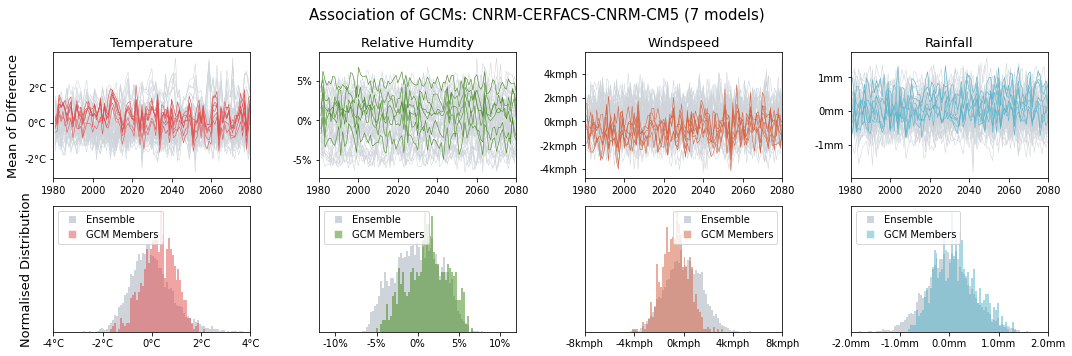

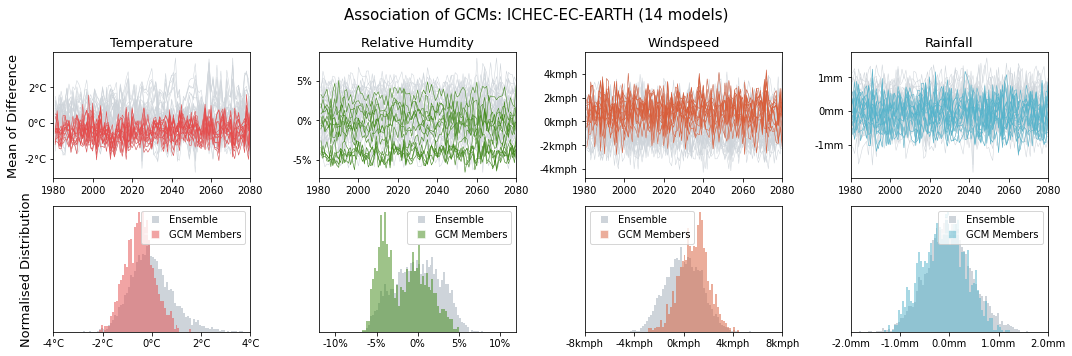

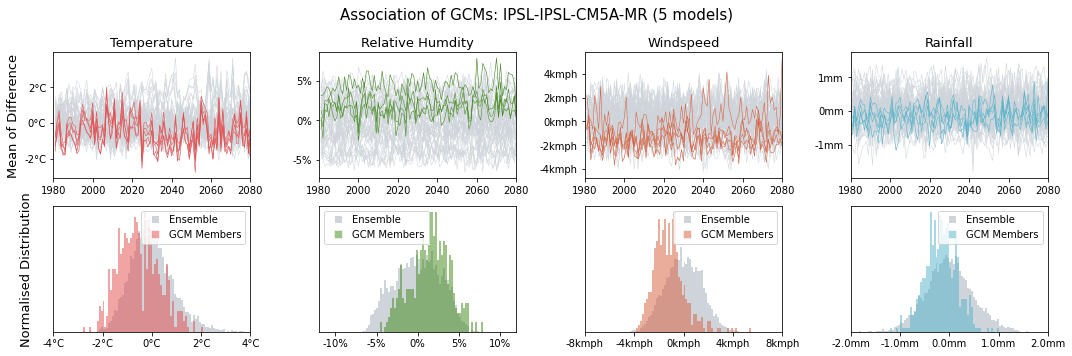

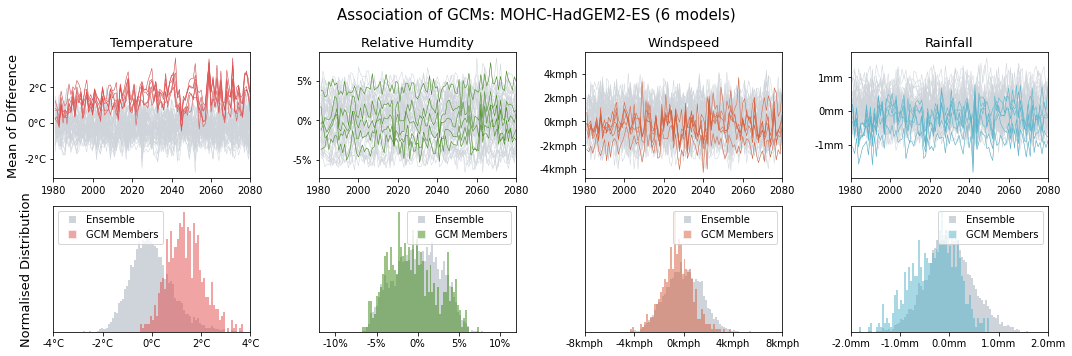

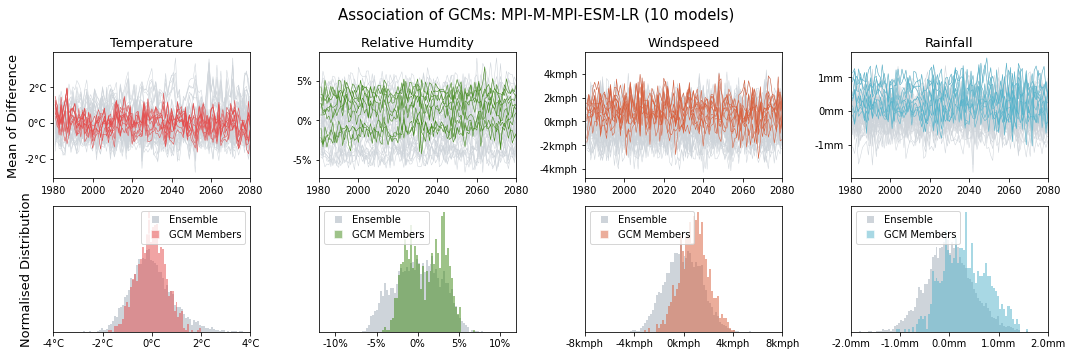

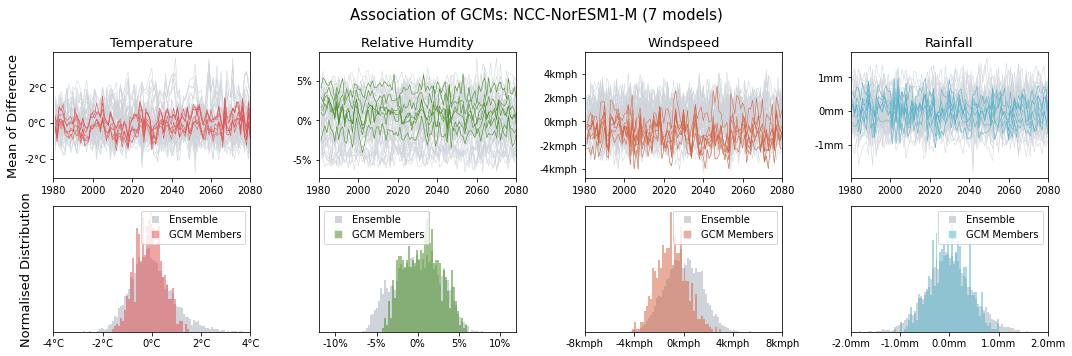

In [14]:
for k in range(len(gcm_inds)):
    fig,ax = plt.subplots(2,4,figsize=(15, 5))
    fig.suptitle(f'Association of GCMs: {gcms[k]} ({len(gcm_inds[k])} models)',fontsize=15)
    gcm_mask = np.zeros((49,100))
    gcm_mask[gcm_inds[k],:] = 1
    gcm_mask[gcm_mask == 0] = np.nan
       
    ax[1,0].hist((tas_data.flatten()),color='#ced4da',bins=100,range=(-4,4))
    ax[1,1].hist((hur_data.flatten()),color='#ced4da',bins=100,range=(-12,12))
    ax[1,2].hist((wnd_data.flatten()),color='#ced4da',bins=100,range=(-8,8))
    ax[1,3].hist((prc_data.flatten()),color='#ced4da',bins=100,range=(-2,2))
    
    tas_gcm = (tas_data*gcm_mask).flatten()
    hur_ini = (hur_data*gcm_mask)
    hur_ini[0,:] = np.nan
    hur_gcm = hur_ini.flatten()
    wnd_gcm = (wnd_data*gcm_mask).flatten()
    prc_gcm = (prc_data*gcm_mask).flatten()
    
    weight = 49/len(gcm_inds[k])
    
    #ax[1,0].hist(tas_gcm,color='#E54B4B',bins=100,range=(-4,4),  weights = tas_fct*np.ones_like(tas_gcm),alpha = 0.5)
    #ax[1,1].hist(hur_gcm,color='#3E8914',bins=100,range=(-12,12),weights = hur_fct*np.ones_like(hur_gcm),alpha = 0.5)
    #ax[1,2].hist(wnd_gcm,color='#D95D39',bins=100,range=(-7,7),  weights = wnd_fct*np.ones_like(wnd_gcm),alpha = 0.5)
    #ax[1,3].hist(prc_gcm,color='#53B3CB',bins=100,range=(-2,2),  weights = prc_fct*np.ones_like(prc_gcm),alpha = 0.5)
    
    ax[1,0].hist((tas_gcm),color='#E54B4B',bins=100,range=(-4,4),  weights = weight*np.ones_like(tas_gcm),alpha = 0.5)
    ax[1,1].hist((hur_gcm),color='#3E8914',bins=100,range=(-12,12),weights = (48/49)*weight*np.ones_like(hur_gcm),alpha = 0.5)
    ax[1,2].hist((wnd_gcm),color='#D95D39',bins=100,range=(-8,8),  weights = weight*np.ones_like(wnd_gcm),alpha = 0.5)
    ax[1,3].hist((prc_gcm),color='#53B3CB',bins=100,range=(-2,2),  weights = weight*np.ones_like(prc_gcm),alpha = 0.5)
    
    legend_items = [mpl.lines.Line2D([0], [0], marker='s', color='w',markerfacecolor='#CED4DA', markersize=8),
                    mpl.lines.Line2D([0], [0], marker='s', color='w',markerfacecolor='#E54B4B', markersize=8, alpha = 0.5),
                    mpl.lines.Line2D([0], [0], marker='s', color='w',markerfacecolor='#3E8914', markersize=8, alpha = 0.5),
                    mpl.lines.Line2D([0], [0], marker='s', color='w',markerfacecolor='#D95D39', markersize=8, alpha = 0.5),
                    mpl.lines.Line2D([0], [0], marker='s', color='w',markerfacecolor='#53B3CB', markersize=8, alpha = 0.5)]
    
    ax[1,0].legend([legend_items[0],legend_items[1]],['Ensemble','GCM Members'],handletextpad=0.4)
    ax[1,1].legend([legend_items[0],legend_items[2]],['Ensemble','GCM Members'],handletextpad=0.4)
    ax[1,2].legend([legend_items[0],legend_items[3]],['Ensemble','GCM Members'],handletextpad=0.4)
    ax[1,3].legend([legend_items[0],legend_items[4]],['Ensemble','GCM Members'],handletextpad=0.4)

    ax[1,0].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}°C"))
    ax[1,1].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}%"))
    ax[1,2].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}kmph"))
    ax[1,3].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:3.1f}mm"))
    
    ax[1,0].xaxis.set_major_locator(plt.MaxNLocator(5))
    ax[1,1].xaxis.set_major_locator(plt.MaxNLocator(5))
    ax[1,2].xaxis.set_major_locator(plt.MaxNLocator(5))
    ax[1,3].xaxis.set_major_locator(plt.MaxNLocator(4))
    
    ax[1,0].set_xlim((-4,4))
    ax[1,1].set_xlim((-12,12))
    ax[1,2].set_xlim((-8,8))
    ax[1,3].set_xlim((-2,2))
    
    ax[1,0].yaxis.set_major_locator(plt.NullLocator())
    ax[1,1].yaxis.set_major_locator(plt.NullLocator())
    ax[1,2].yaxis.set_major_locator(plt.NullLocator())
    ax[1,3].yaxis.set_major_locator(plt.NullLocator())
    
    ax[0,0].set_ylabel('Mean of Difference', fontsize = 13)
    ax[1,0].set_ylabel('Normalised Distribution', fontsize = 13, labelpad = 20)
    
    # Right: All the lines
    dates = np.array([1981 + i for i in range(100)])
    
    ax[0,0].set_title('Temperature', fontsize = 13)
    ax[0,1].set_title('Relative Humdity', fontsize = 13)
    ax[0,2].set_title('Windspeed', fontsize = 13)
    ax[0,3].set_title('Rainfall', fontsize = 13)
    
    ax[0,0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}°C"))
    ax[0,1].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}%"))
    ax[0,2].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}kmph"))
    ax[0,3].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}mm"))
    
    for i in range(49):
        ax[0,0].plot(dates,tas_data[i,:],color='#ced4da',linewidth=0.5)
        if i != 0: # Elimating the corrupted hurs output model (i=0)
            ax[0,1].plot(dates,hur_data[i,:],color='#ced4da',linewidth=0.5)
        ax[0,2].plot(dates,wnd_data[i,:],color='#ced4da',linewidth=0.5)
        ax[0,3].plot(dates,prc_data[i,:],color='#ced4da',linewidth=0.5)

    for i in range(len(gcm_inds[k])):
        ax[0,0].plot(dates,tas_data[gcm_inds[k][i],:],color='#E54B4B',linewidth=0.5)
        if i != 0: # Elimating the corrupted hurs output model (i=0)
            ax[0,1].plot(dates,hur_data[gcm_inds[k][i],:],color='#3E8914',linewidth=0.5)
        ax[0,2].plot(dates,wnd_data[gcm_inds[k][i],:],color='#D95D39',linewidth=0.5)
        ax[0,3].plot(dates,prc_data[gcm_inds[k][i],:],color='#53B3CB',linewidth=0.5)
    
    ax[0,0].set_xlim((1980,2080))
    ax[0,1].set_xlim((1980,2080))
    ax[0,2].set_xlim((1980,2080))
    ax[0,3].set_xlim((1980,2080))
    
    plt.tight_layout()
    plt.savefig(f'/home/theo/final_images/3.2.images/GCM_____{gcms[k]}')

###### RCM Association:

In [10]:
for i in range(len(rcm_inds)):
    print(rcm_inds[i])

[0, 7, 8, 9, 26, 32, 33, 34, 42]
[1, 10, 27, 35, 43]
[2, 11, 12, 13, 21, 28, 36, 44]
[3, 14, 15, 16, 22, 29, 37, 45]
[4, 17, 18, 19, 23, 30, 38, 39, 40, 46]
[5, 24, 41, 47]
[6, 20, 25, 31, 48]


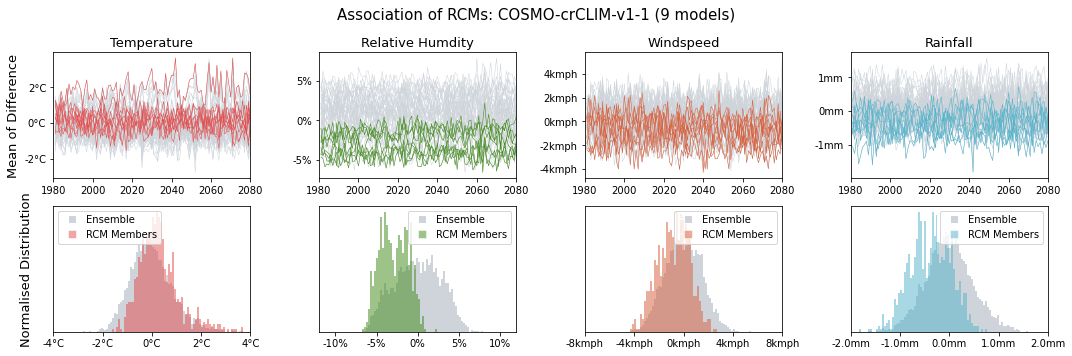

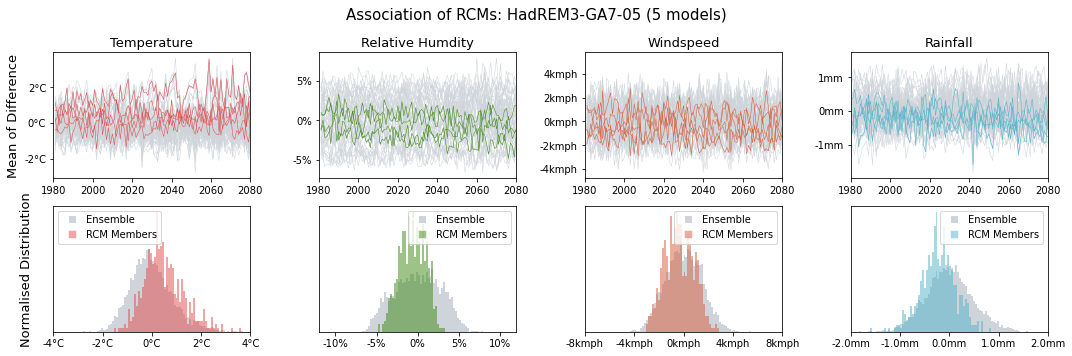

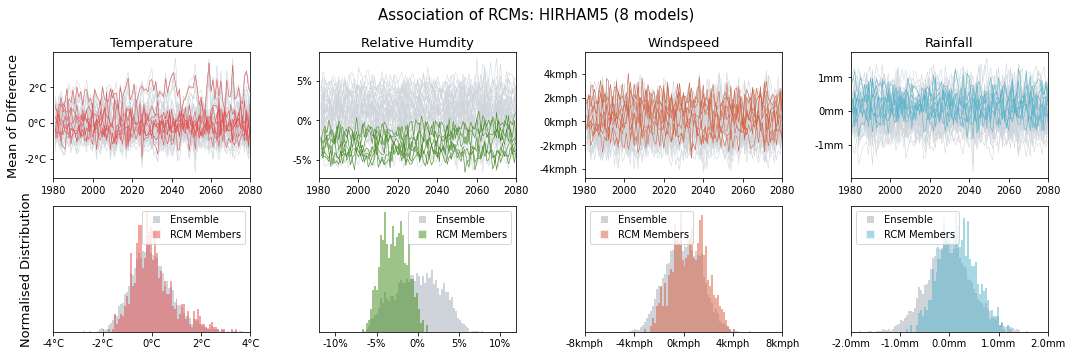

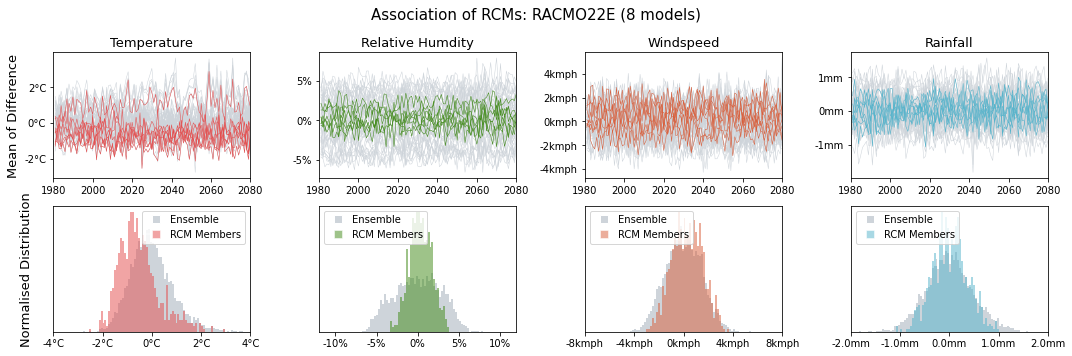

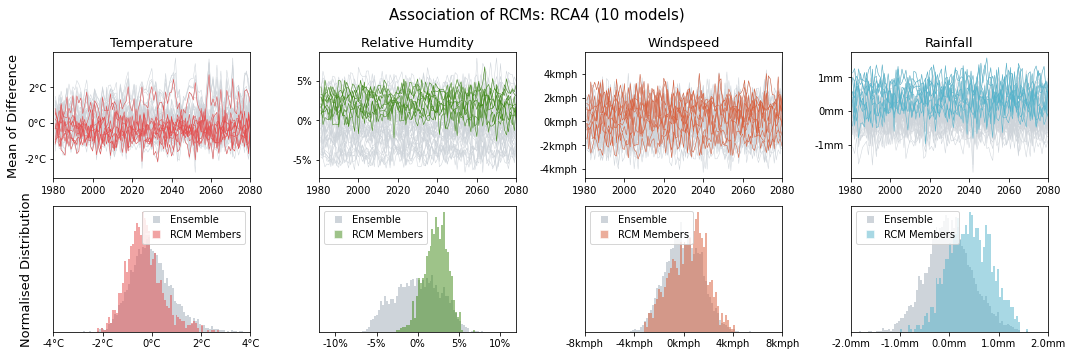

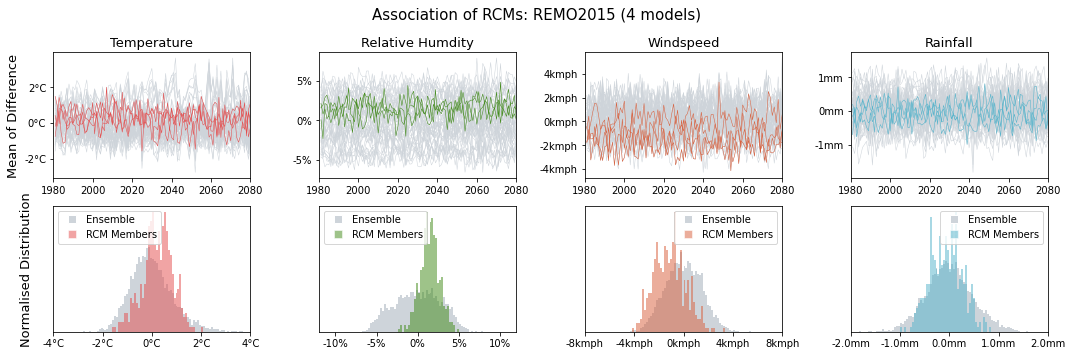

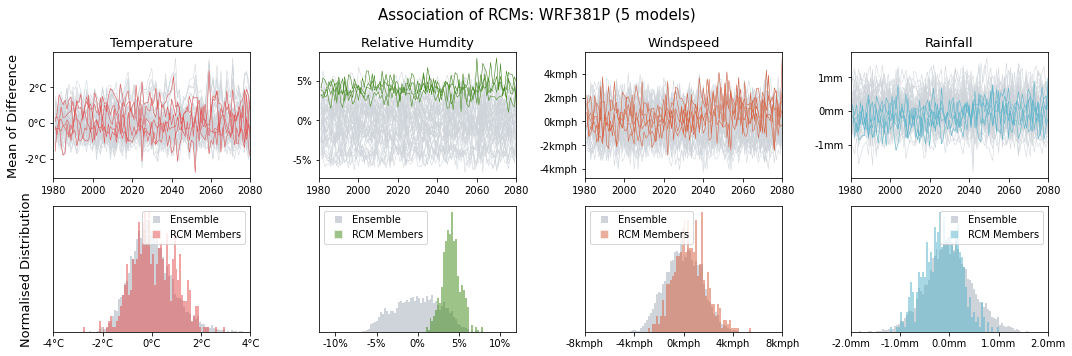

In [15]:
for k in range(len(rcm_inds)):
    fig,ax = plt.subplots(2,4,figsize=(15, 5))
    fig.suptitle(f'Association of RCMs: {rcms[k]} ({len(rcm_inds[k])} models)',fontsize=15)
    rcm_mask = np.zeros((49,100))
    rcm_mask[rcm_inds[k],:] = 1
    rcm_mask[rcm_mask == 0] = np.nan
       
    ax[1,0].hist((tas_data.flatten()),color='#ced4da',bins=100,range=(-4,4))
    ax[1,1].hist((hur_data.flatten()),color='#ced4da',bins=100,range=(-12,12))
    ax[1,2].hist((wnd_data.flatten()),color='#ced4da',bins=100,range=(-8,8))
    ax[1,3].hist((prc_data.flatten()),color='#ced4da',bins=100,range=(-2,2))
    
    tas_rcm = (tas_data*rcm_mask).flatten()
    hur_ini = (hur_data*rcm_mask)
    hur_ini[0,:] = np.nan
    hur_rcm = hur_ini.flatten()
    wnd_rcm = (wnd_data*rcm_mask).flatten()
    prc_rcm = (prc_data*rcm_mask).flatten()
    
    weight = 49/len(rcm_inds[k])
    
    ax[1,0].hist((tas_rcm),color='#E54B4B',bins=100,range=(-4,4),  weights = weight*np.ones_like(tas_rcm),alpha = 0.5)
    ax[1,1].hist((hur_rcm),color='#3E8914',bins=100,range=(-12,12),weights = (48/49)*weight*np.ones_like(hur_rcm),alpha = 0.5)
    ax[1,2].hist((wnd_rcm),color='#D95D39',bins=100,range=(-8,8),  weights = weight*np.ones_like(wnd_rcm),alpha = 0.5)
    ax[1,3].hist((prc_rcm),color='#53B3CB',bins=100,range=(-2,2),  weights = weight*np.ones_like(prc_rcm),alpha = 0.5)
    
    legend_items = [mpl.lines.Line2D([0], [0], marker='s', color='w',markerfacecolor='#CED4DA', markersize=8),
                    mpl.lines.Line2D([0], [0], marker='s', color='w',markerfacecolor='#E54B4B', markersize=8, alpha = 0.5),
                    mpl.lines.Line2D([0], [0], marker='s', color='w',markerfacecolor='#3E8914', markersize=8, alpha = 0.5),
                    mpl.lines.Line2D([0], [0], marker='s', color='w',markerfacecolor='#D95D39', markersize=8, alpha = 0.5),
                    mpl.lines.Line2D([0], [0], marker='s', color='w',markerfacecolor='#53B3CB', markersize=8, alpha = 0.5)]
    
    ax[1,0].legend([legend_items[0],legend_items[1]],['Ensemble','RCM Members'],handletextpad=0.4)
    ax[1,1].legend([legend_items[0],legend_items[2]],['Ensemble','RCM Members'],handletextpad=0.4)
    ax[1,2].legend([legend_items[0],legend_items[3]],['Ensemble','RCM Members'],handletextpad=0.4)
    ax[1,3].legend([legend_items[0],legend_items[4]],['Ensemble','RCM Members'],handletextpad=0.4)
    
    
    ax[1,0].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}°C"))
    ax[1,1].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}%"))
    ax[1,2].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}kmph"))
    ax[1,3].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:3.1f}mm"))
    
    ax[1,0].xaxis.set_major_locator(plt.MaxNLocator(5))
    ax[1,1].xaxis.set_major_locator(plt.MaxNLocator(5))
    ax[1,2].xaxis.set_major_locator(plt.MaxNLocator(5))
    ax[1,3].xaxis.set_major_locator(plt.MaxNLocator(4))
    
    ax[1,0].set_xlim((-4,4))
    ax[1,1].set_xlim((-12,12))
    ax[1,2].set_xlim((-8,8))
    ax[1,3].set_xlim((-2,2))
    
    ax[1,0].yaxis.set_major_locator(plt.NullLocator())
    ax[1,1].yaxis.set_major_locator(plt.NullLocator())
    ax[1,2].yaxis.set_major_locator(plt.NullLocator())
    ax[1,3].yaxis.set_major_locator(plt.NullLocator())
    
    ax[0,0].set_ylabel('Mean of Difference', fontsize = 13)
    ax[1,0].set_ylabel('Normalised Distribution', fontsize = 13, labelpad = 20)
    
    # Right: All the lines
    dates = np.array([1981 + i for i in range(100)])
    
    ax[0,0].set_title('Temperature', fontsize = 13)
    ax[0,1].set_title('Relative Humdity', fontsize = 13)
    ax[0,2].set_title('Windspeed', fontsize = 13)
    ax[0,3].set_title('Rainfall', fontsize = 13)
    
    ax[0,0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}°C"))
    ax[0,1].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}%"))
    ax[0,2].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}kmph"))
    ax[0,3].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}mm"))
    
    for i in range(49):
        ax[0,0].plot(dates,tas_data[i,:],color='#ced4da',linewidth=0.5)
        if i != 0: # Elimating the corrupted hurs output model (i=0)
            ax[0,1].plot(dates,hur_data[i,:],color='#ced4da',linewidth=0.5)
        ax[0,2].plot(dates,wnd_data[i,:],color='#ced4da',linewidth=0.5)
        ax[0,3].plot(dates,prc_data[i,:],color='#ced4da',linewidth=0.5)

    for i in range(len(rcm_inds[k])):
        ax[0,0].plot(dates,tas_data[rcm_inds[k][i],:],color='#E54B4B',linewidth=0.5)
        if i != 0: # Elimating the corrupted hurs output model (i=0)
            ax[0,1].plot(dates,hur_data[rcm_inds[k][i],:],color='#3E8914',linewidth=0.5)
        ax[0,2].plot(dates,wnd_data[rcm_inds[k][i],:],color='#D95D39',linewidth=0.5)
        ax[0,3].plot(dates,prc_data[rcm_inds[k][i],:],color='#53B3CB',linewidth=0.5)
    
    ax[0,0].set_xlim((1980,2080))
    ax[0,1].set_xlim((1980,2080))
    ax[0,2].set_xlim((1980,2080))
    ax[0,3].set_xlim((1980,2080))
    
    plt.tight_layout()
    plt.savefig(f'/home/theo/final_images/3.2.images/RCM_____{rcms[k]}')

32.666666666666664
32.666666666666664
32.666666666666664
117.6
117.6
117.6
42.0
42.0
42.0
42.0
42.0
42.0
26.133333333333333
26.133333333333333
26.133333333333333
196.0
196.0
196.0
117.6
117.6
117.6


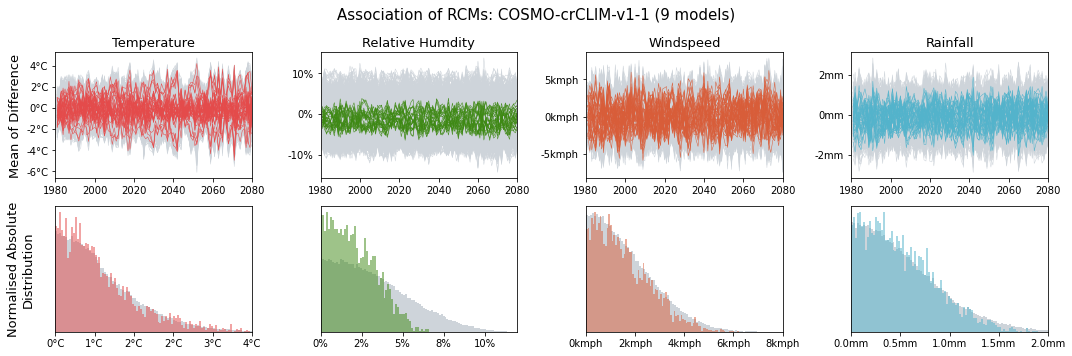

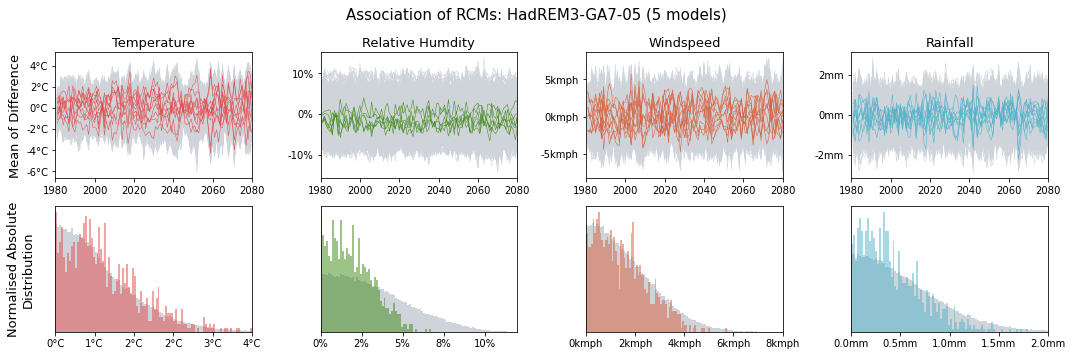

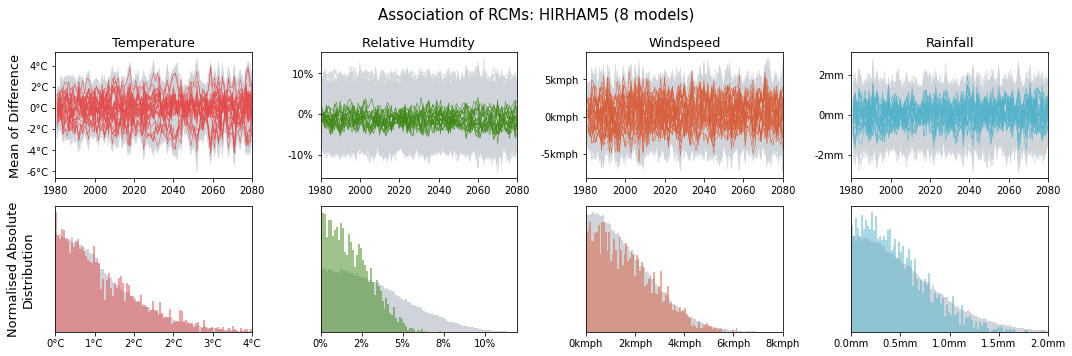

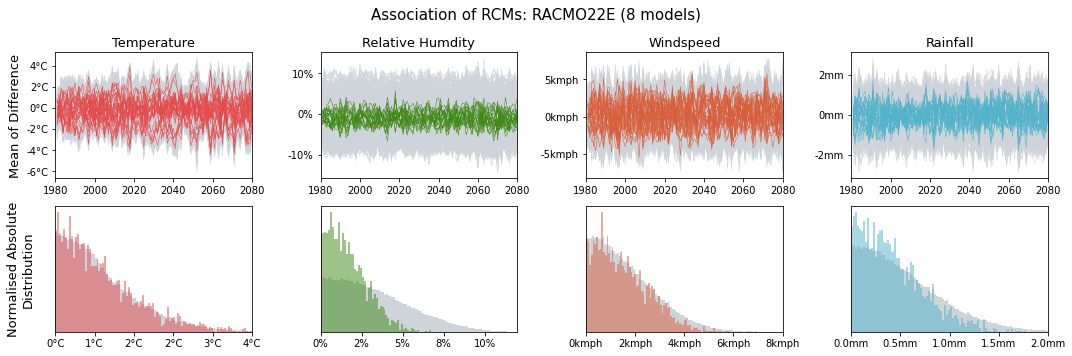

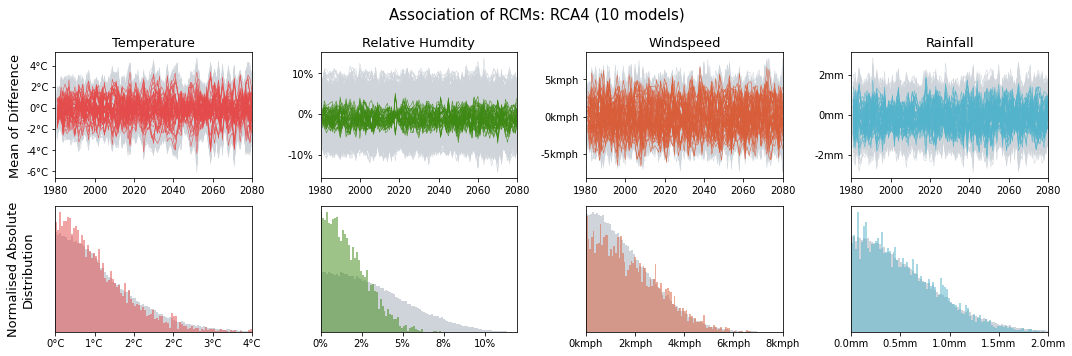

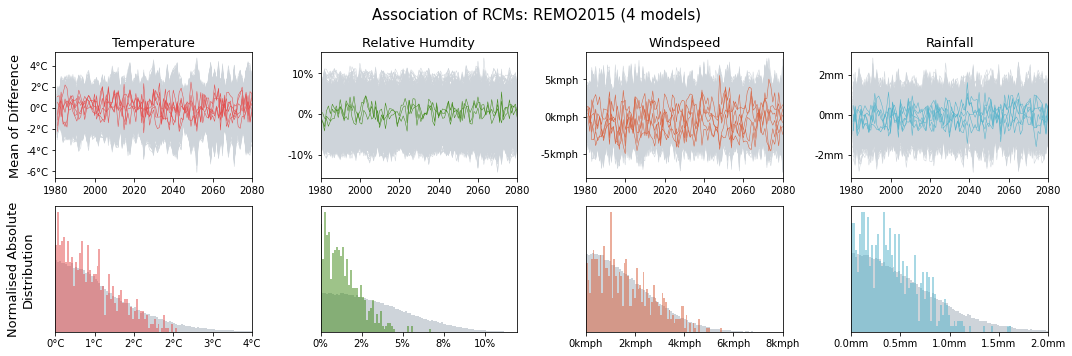

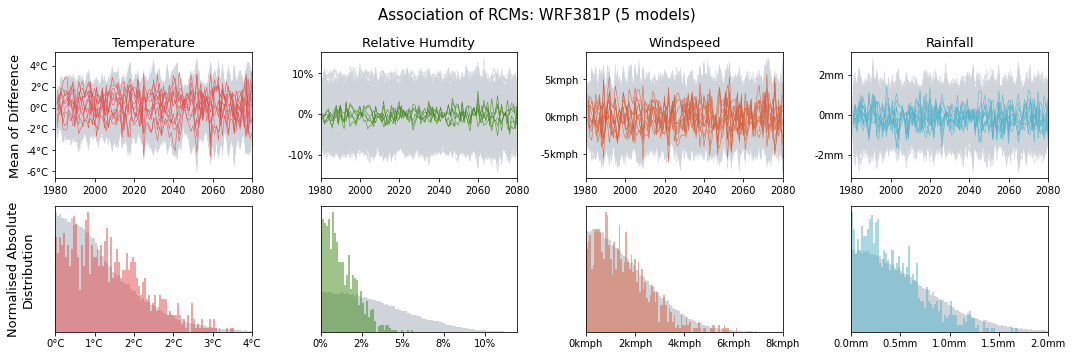

In [112]:
for k in range(len(rcm_inds)):
    fig,ax = plt.subplots(2,4,figsize=(15, 5))
    fig.suptitle(f'Association of RCMs: {rcms[k]} ({len(rcm_inds[k])} models)',fontsize=15)
    # Left: Histogram/ bell curve situation
    base_mask = np.triu(np.ones((49,49)),k=1)
    base_mask[base_mask == 0] = np.nan

    rcm_mask = np.zeros((49,49))
    for i in range(len(rcm_inds[k])):
        for j in range(len(rcm_inds[k])):
            if rcm_inds[k][j] > rcm_inds[k][i]:
                rcm_mask[rcm_inds[k][i],rcm_inds[k][j]] = 1
    rcm_mask[rcm_mask == 0] = np.nan
    
    tas_base = np.einsum('ijk,ij->ijk',tas_data,base_mask).flatten()
    hur_init = np.einsum('ijk,ij->ijk',hur_data,base_mask)
    hur_init[0,:] = np.nan
    hur_base = hur_init.flatten()
    wnd_base = np.einsum('ijk,ij->ijk',wnd_data,base_mask).flatten()
    prc_base = np.einsum('ijk,ij->ijk',prc_data,base_mask).flatten()
    
    #ax[1,0].hist(tas_base,color='#ced4da',bins=100,range=(-4,4))
    #ax[1,1].hist(hur_base,color='#ced4da',bins=100,range=(-12,12))
    #ax[1,2].hist(wnd_base,color='#ced4da',bins=100,range=(-8,8))
    #ax[1,3].hist(prc_base,color='#ced4da',bins=100,range=(-2,2))
    
    ax[1,0].hist(np.absolute(tas_base),color='#ced4da',bins=100,range=(0,4))
    ax[1,1].hist(np.absolute(hur_base),color='#ced4da',bins=100,range=(0,12))
    ax[1,2].hist(np.absolute(wnd_base),color='#ced4da',bins=100,range=(0,8))
    ax[1,3].hist(np.absolute(prc_base),color='#ced4da',bins=100,range=(0,2))
    
    tas_rcm = np.einsum('ijk,ij->ijk',tas_data,rcm_mask).flatten()
    hur_ini = np.einsum('ijk,ij->ijk',hur_data,rcm_mask)
    hur_ini[0,:] = np.nan
    hur_rcm = hur_ini.flatten()
    wnd_rcm = np.einsum('ijk,ij->ijk',wnd_data,rcm_mask).flatten()
    prc_rcm = np.einsum('ijk,ij->ijk',prc_data,rcm_mask).flatten()
    
    tas_fct = float((~np.isnan(tas_base)).sum()/(~np.isnan(tas_rcm)).sum())
    hur_fct = float((~np.isnan(hur_base)).sum()/(~np.isnan(hur_rcm)).sum())
    wnd_fct = float((~np.isnan(wnd_base)).sum()/(~np.isnan(wnd_rcm)).sum())
    prc_fct = float((~np.isnan(prc_base)).sum()/(~np.isnan(prc_rcm)).sum())
    
    print(tas_fct)
    print(wnd_fct)
    print(prc_fct)
    
    #ax[1,0].hist(tas_gcm,color='#E54B4B',bins=100,range=(-4,4),  weights = tas_fct*np.ones_like(tas_gcm),alpha = 0.5)
    #ax[1,1].hist(hur_gcm,color='#3E8914',bins=100,range=(-12,12),weights = hur_fct*np.ones_like(hur_gcm),alpha = 0.5)
    #ax[1,2].hist(wnd_gcm,color='#D95D39',bins=100,range=(-7,7),  weights = wnd_fct*np.ones_like(wnd_gcm),alpha = 0.5)
    #ax[1,3].hist(prc_gcm,color='#53B3CB',bins=100,range=(-2,2),  weights = prc_fct*np.ones_like(prc_gcm),alpha = 0.5)
    
    ax[1,0].hist(np.absolute(tas_rcm),color='#E54B4B',bins=100,range=(0,4),  weights = tas_fct*np.ones_like(tas_rcm),alpha = 0.5)
    ax[1,1].hist(np.absolute(hur_rcm),color='#3E8914',bins=100,range=(0,12),weights = hur_fct*np.ones_like(hur_rcm),alpha = 0.5)
    ax[1,2].hist(np.absolute(wnd_rcm),color='#D95D39',bins=100,range=(0,7),  weights = wnd_fct*np.ones_like(wnd_rcm),alpha = 0.5)
    ax[1,3].hist(np.absolute(prc_rcm),color='#53B3CB',bins=100,range=(0,2),  weights = prc_fct*np.ones_like(prc_rcm),alpha = 0.5)

    ax[1,0].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}°C"))
    ax[1,1].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}%"))
    ax[1,2].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}kmph"))
    ax[1,3].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:3.1f}mm"))
    
    ax[1,0].xaxis.set_major_locator(plt.MaxNLocator(5))
    ax[1,1].xaxis.set_major_locator(plt.MaxNLocator(5))
    ax[1,2].xaxis.set_major_locator(plt.MaxNLocator(5))
    ax[1,3].xaxis.set_major_locator(plt.MaxNLocator(4))
    
    ax[1,0].set_xlim((0,4))
    ax[1,1].set_xlim((0,12))
    ax[1,2].set_xlim((0,8))
    ax[1,3].set_xlim((0,2))
    
    ax[1,0].yaxis.set_major_locator(plt.NullLocator())
    ax[1,1].yaxis.set_major_locator(plt.NullLocator())
    ax[1,2].yaxis.set_major_locator(plt.NullLocator())
    ax[1,3].yaxis.set_major_locator(plt.NullLocator())
    
    ax[0,0].set_ylabel('Mean of Difference', fontsize = 13)
    ax[1,0].set_ylabel('Normalised Absolute\nDistribution', fontsize = 13, labelpad = 20)
    
    # Right: All the lines
    dates = np.array([1981 + i for i in range(100)])
    
    ax[0,0].set_title('Temperature', fontsize = 13)
    ax[0,1].set_title('Relative Humdity', fontsize = 13)
    ax[0,2].set_title('Windspeed', fontsize = 13)
    ax[0,3].set_title('Rainfall', fontsize = 13)
    
    ax[0,0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}°C"))
    ax[0,1].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}%"))
    ax[0,2].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}kmph"))
    ax[0,3].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}mm"))
    
    for i in range(49):
        for j in range(49):
            if j > i:
                ax[0,0].plot(dates,tas_data[i,j,:],color='#ced4da',linewidth=0.5)
                if i != 0: # Elimating the corrupted hurs output model (i=0)
                    ax[0,1].plot(dates,hur_data[i,j,:],color='#ced4da',linewidth=0.5)
                ax[0,2].plot(dates,wnd_data[i,j,:],color='#ced4da',linewidth=0.5)
                ax[0,3].plot(dates,prc_data[i,j,:],color='#ced4da',linewidth=0.5)

    for i in range(len(rcm_inds[k])):
        for j in range(len(rcm_inds[k])):
            if j > i:
                ax[0,0].plot(dates,tas_data[rcm_inds[k][i],rcm_inds[k][j],:],color='#E54B4B',linewidth=0.5)
                if i != 0: # Elimating the corrupted hurs output model (i=0)
                    ax[0,1].plot(dates,hur_data[rcm_inds[k][i],rcm_inds[k][j],:],color='#3E8914',linewidth=0.5)
                ax[0,2].plot(dates,wnd_data[rcm_inds[k][i],rcm_inds[k][j],:],color='#D95D39',linewidth=0.5)
                ax[0,3].plot(dates,prc_data[rcm_inds[k][i],rcm_inds[k][j],:],color='#53B3CB',linewidth=0.5)
    
    ax[0,0].set_xlim((1980,2080))
    ax[0,1].set_xlim((1980,2080))
    ax[0,2].set_xlim((1980,2080))
    ax[0,3].set_xlim((1980,2080))
    
    plt.tight_layout()
    plt.savefig(f'/home/theo/final_images/3.2.images/RCM_____{rcms[k]}')

###### Ensemble Association:

In [102]:
for i in range(len(ensemble_inds)):
    print(ensemble_inds[i])

[0, 1, 2, 3, 4, 5, 6, 8, 12, 15, 18, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 35, 36, 37, 38, 42, 43, 44, 45, 46, 47, 48]
[33, 39]
[9, 13, 16, 19, 34, 40, 41]
[7, 10, 11, 14, 17, 20]


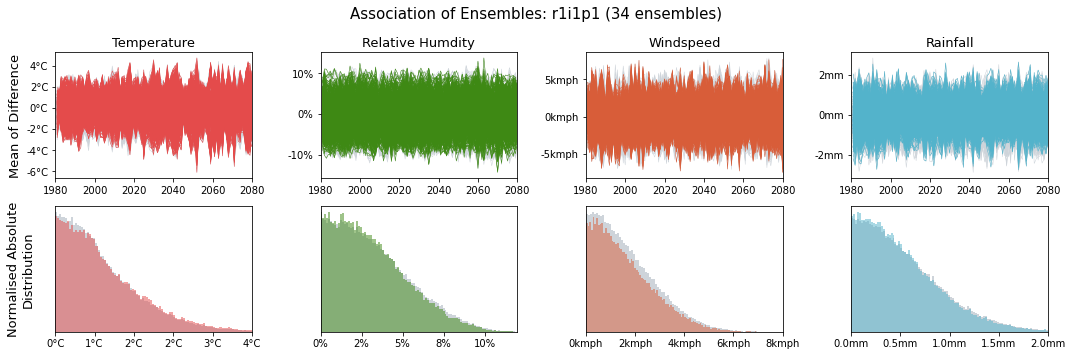

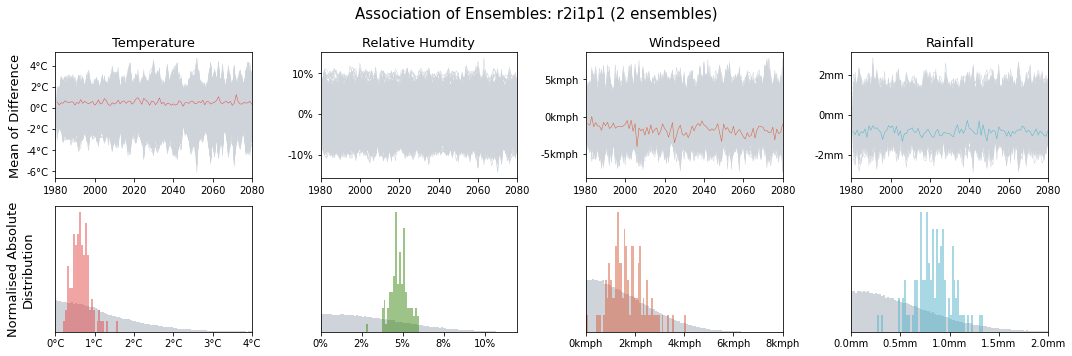

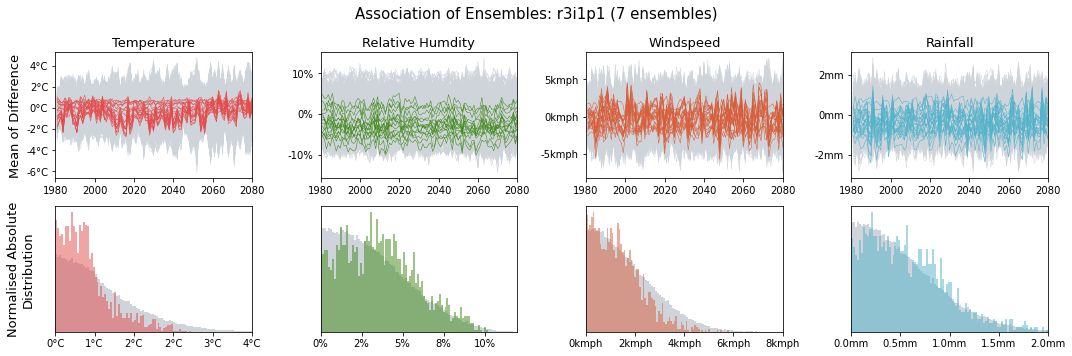

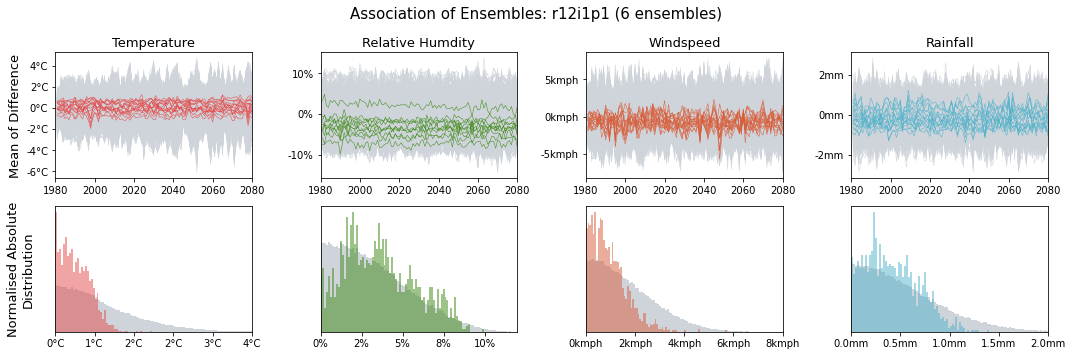

In [111]:
for k in range(len(ensemble_inds)):
    fig,ax = plt.subplots(2,4,figsize=(15, 5))
    fig.suptitle(f'Association of Ensembles: {ensembles[k]} ({len(ensemble_inds[k])} ensembles)',fontsize=15)
    # Left: Histogram/ bell curve situation
    base_mask = np.triu(np.ones((49,49)),k=1)
    base_mask[base_mask == 0] = np.nan

    ensemble_mask = np.zeros((49,49))
    for i in range(len(ensemble_inds[k])):
        for j in range(len(ensemble_inds[k])):
            if ensemble_inds[k][j] > ensemble_inds[k][i]:
                ensemble_mask[ensemble_inds[k][i],ensemble_inds[k][j]] = 1
    ensemble_mask[ensemble_mask == 0] = np.nan
    
    tas_base = np.einsum('ijk,ij->ijk',tas_data,base_mask).flatten()
    hur_init = np.einsum('ijk,ij->ijk',hur_data,base_mask)
    hur_init[0,:] = np.nan
    hur_base = hur_init.flatten()
    wnd_base = np.einsum('ijk,ij->ijk',wnd_data,base_mask).flatten()
    prc_base = np.einsum('ijk,ij->ijk',prc_data,base_mask).flatten()
    
    #ax[1,0].hist(tas_base,color='#ced4da',bins=100,range=(-4,4))
    #ax[1,1].hist(hur_base,color='#ced4da',bins=100,range=(-12,12))
    #ax[1,2].hist(wnd_base,color='#ced4da',bins=100,range=(-8,8))
    #ax[1,3].hist(prc_base,color='#ced4da',bins=100,range=(-2,2))
    
    ax[1,0].hist(np.absolute(tas_base),color='#ced4da',bins=100,range=(0,4))
    ax[1,1].hist(np.absolute(hur_base),color='#ced4da',bins=100,range=(0,12))
    ax[1,2].hist(np.absolute(wnd_base),color='#ced4da',bins=100,range=(0,8))
    ax[1,3].hist(np.absolute(prc_base),color='#ced4da',bins=100,range=(0,2))
    
    tas_ensemble = np.einsum('ijk,ij->ijk',tas_data,ensemble_mask).flatten()
    hur_ini = np.einsum('ijk,ij->ijk',hur_data,ensemble_mask)
    hur_ini[0,:] = np.nan
    hur_ensemble = hur_ini.flatten()
    wnd_ensemble = np.einsum('ijk,ij->ijk',wnd_data,ensemble_mask).flatten()
    prc_ensemble = np.einsum('ijk,ij->ijk',prc_data,ensemble_mask).flatten()
    
    tas_fct = float((~np.isnan(tas_base)).sum()/(~np.isnan(tas_ensemble)).sum())
    hur_fct = float((~np.isnan(hur_base)).sum()/(~np.isnan(hur_ensemble)).sum())
    wnd_fct = float((~np.isnan(wnd_base)).sum()/(~np.isnan(wnd_ensemble)).sum())
    prc_fct = float((~np.isnan(prc_base)).sum()/(~np.isnan(prc_ensemble)).sum())
    
    #ax[1,0].hist(tas_gcm,color='#E54B4B',bins=100,range=(-4,4),  weights = tas_fct*np.ones_like(tas_gcm),alpha = 0.5)
    #ax[1,1].hist(hur_gcm,color='#3E8914',bins=100,range=(-12,12),weights = hur_fct*np.ones_like(hur_gcm),alpha = 0.5)
    #ax[1,2].hist(wnd_gcm,color='#D95D39',bins=100,range=(-7,7),  weights = wnd_fct*np.ones_like(wnd_gcm),alpha = 0.5)
    #ax[1,3].hist(prc_gcm,color='#53B3CB',bins=100,range=(-2,2),  weights = prc_fct*np.ones_like(prc_gcm),alpha = 0.5)
    
    ax[1,0].hist(np.absolute(tas_ensemble),color='#E54B4B',bins=100,range=(0,4),  weights = tas_fct*np.ones_like(tas_ensemble),alpha = 0.5)
    ax[1,1].hist(np.absolute(hur_ensemble),color='#3E8914',bins=100,range=(0,12),weights = hur_fct*np.ones_like(hur_ensemble),alpha = 0.5)
    ax[1,2].hist(np.absolute(wnd_ensemble),color='#D95D39',bins=100,range=(0,7),  weights = wnd_fct*np.ones_like(wnd_ensemble),alpha = 0.5)
    ax[1,3].hist(np.absolute(prc_ensemble),color='#53B3CB',bins=100,range=(0,2),  weights = prc_fct*np.ones_like(prc_ensemble),alpha = 0.5)

    ax[1,0].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}°C"))
    ax[1,1].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}%"))
    ax[1,2].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}kmph"))
    ax[1,3].xaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:3.1f}mm"))
    
    ax[1,0].xaxis.set_major_locator(plt.MaxNLocator(5))
    ax[1,1].xaxis.set_major_locator(plt.MaxNLocator(5))
    ax[1,2].xaxis.set_major_locator(plt.MaxNLocator(5))
    ax[1,3].xaxis.set_major_locator(plt.MaxNLocator(4))
    
    ax[1,0].set_xlim((0,4))
    ax[1,1].set_xlim((0,12))
    ax[1,2].set_xlim((0,8))
    ax[1,3].set_xlim((0,2))
    
    ax[1,0].yaxis.set_major_locator(plt.NullLocator())
    ax[1,1].yaxis.set_major_locator(plt.NullLocator())
    ax[1,2].yaxis.set_major_locator(plt.NullLocator())
    ax[1,3].yaxis.set_major_locator(plt.NullLocator())
    
    ax[0,0].set_ylabel('Mean of Difference', fontsize = 13)
    ax[1,0].set_ylabel('Normalised Absolute\nDistribution', fontsize = 13, labelpad = 20)
    
    # Right: All the lines
    dates = np.array([1981 + i for i in range(100)])
    
    ax[0,0].set_title('Temperature', fontsize = 13)
    ax[0,1].set_title('Relative Humdity', fontsize = 13)
    ax[0,2].set_title('Windspeed', fontsize = 13)
    ax[0,3].set_title('Rainfall', fontsize = 13)
    
    ax[0,0].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}°C"))
    ax[0,1].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}%"))
    ax[0,2].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}kmph"))
    ax[0,3].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter(u"{x:.0f}mm"))
    
    for i in range(49):
        for j in range(49):
            if j > i:
                ax[0,0].plot(dates,tas_data[i,j,:],color='#ced4da',linewidth=0.5)
                if i != 0: # Elimating the corrupted hurs output model (i=0)
                    ax[0,1].plot(dates,hur_data[i,j,:],color='#ced4da',linewidth=0.5)
                ax[0,2].plot(dates,wnd_data[i,j,:],color='#ced4da',linewidth=0.5)
                ax[0,3].plot(dates,prc_data[i,j,:],color='#ced4da',linewidth=0.5)

    for i in range(len(ensemble_inds[k])):
        for j in range(len(ensemble_inds[k])):
            if j > i:
                ax[0,0].plot(dates,tas_data[ensemble_inds[k][i],ensemble_inds[k][j],:],color='#E54B4B',linewidth=0.5)
                if i != 0: # Elimating the corrupted hurs output model (i=0)
                    ax[0,1].plot(dates,hur_data[ensemble_inds[k][i],ensemble_inds[k][j],:],color='#3E8914',linewidth=0.5)
                ax[0,2].plot(dates,wnd_data[ensemble_inds[k][i],ensemble_inds[k][j],:],color='#D95D39',linewidth=0.5)
                ax[0,3].plot(dates,prc_data[ensemble_inds[k][i],ensemble_inds[k][j],:],color='#53B3CB',linewidth=0.5)
    
    ax[0,0].set_xlim((1980,2080))
    ax[0,1].set_xlim((1980,2080))
    ax[0,2].set_xlim((1980,2080))
    ax[0,3].set_xlim((1980,2080))
    
    plt.tight_layout()
    plt.savefig(f'/home/theo/final_images/3.2.images/Ensemble_____{ensembles[k]}')